# Estimate position

References:  
> https://github.com/RaubCamaioni/OpenCV_Position.git  
> https://medium.com/analytics-vidhya/using-homography-for-pose-estimation-in-opencv-a7215f260fdd  

## Imports and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
points_printed = np.loadtxt('../coords_of_arrow.txt')
print(points_printed)
print('-------------')
points_printed = points_printed[np.lexsort((points_printed[:,1], points_printed[:,0]))] # start with most left
print(points_printed)

[[   0.  118.]
 [  45.   61.]
 [ -45.   61.]
 [ -22. -118.]
 [  22. -118.]]
-------------
[[ -45.   61.]
 [ -22. -118.]
 [   0.  118.]
 [  22. -118.]
 [  45.   61.]]


In [3]:
K = np.loadtxt('../../cam-config/mtx.txt')
K

array([[655.19135007,   0.        , 319.04529769],
       [  0.        , 655.56447367, 223.19439802],
       [  0.        ,   0.        ,   1.        ]])

In [4]:
COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

In [5]:
def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

In [6]:
def rotate_and_crop(image, min_area_rect):
    factor = 1.3

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        angle = -1 * (90 - min_area_rect[2])
    else:
        angle = min_area_rect[2]    
        
    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center) 
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)
    
    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated


In [7]:
def extract_cnts(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.blur(gray_img, (3,3))
    
    sigma = 0.33
    v = np.median(blurred)
    
    #---- apply automatic Canny edge detection using the computed median----
    lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
    upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
    thresh_img = cv2.Canny(blurred, lower, upper)
    cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cnts, gray_img

In [8]:
def filter_cnts(cnts, gray_img):
    filtered_list = []
    pos_filtered_to_pos_source = {}
    pos_filtered = 0
    center_list = []
    too_close = False
    for pos_source, con in enumerate(cnts):
        min_rect = cv2.minAreaRect(con)
        center, size, angle = min_rect
        area = size[0] * size[1]

        if area < AREA_BORDER:
            continue
    
        low_value = min(size[0], size[1])
        high_value = max(size[0], size[1])
        width_to_height = low_value / high_value
    
        if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
            for c_point in center_list:
                too_close = np.all(np.isclose(center, c_point, rtol=0, atol=20))
                if too_close:
                    break
    
            if too_close:
                continue
            center_list.append(center)
            cropped_img = rotate_and_crop(gray_img, min_rect)            
            small_img = cv2.resize(cropped_img, COMPARED_SIZE)
            filtered_list.append(small_img)
            pos_filtered_to_pos_source[pos_filtered] = pos_source
            pos_filtered += 1
    
    filtered_list = np.array(filtered_list)   
    return filtered_list, pos_filtered_to_pos_source

In [9]:
def sort_cnts(prediction, pos_filtered_to_pos_source, cnts):
    positive_contours = []
    negative_contours = []
    
    for pos, value in enumerate(prediction):
        idx = pos_filtered_to_pos_source[pos]
        if value[0] >= 0.5:
            positive_contours.append(cnts[idx])
        else:
            negative_contours.append(cnts[idx])

    return positive_contours, negative_contours

In [10]:
def extract_feature_pts_first_cnt(positive_contours):
    M = cv2.moments(positive_contours[0])
    if (M["m00"] != 0):
        x_c = int(M["m10"] / M["m00"])
        y_c = int(M["m01"] / M["m00"])
    else:
        x_c = -1
        y_c = -1
    retval = cv2.arcLength(positive_contours[0], True)
    points = cv2.approxPolyDP(positive_contours[0], 0.04 * retval, True)
    return points

In [11]:
def merge_points(points, MAX_MERGE_DIST = 4):
    to_merge = []
    checked_points_idx = []
    last_to_merge = False
    for idx in range(len(points)-1):
        first_point = points[idx, 0]
        if idx not in checked_points_idx:
            to_merge_bundle = [first_point]
            
            for idx2 in range(idx+1, len(points)):
                second_point = points[idx2, 0]
                dist = np.abs(first_point - second_point)
                
                if dist[0] < MAX_MERGE_DIST and dist[1] < MAX_MERGE_DIST:
                    to_merge_bundle.append(second_point)
                    checked_points_idx.append(idx2)
                    if idx2 == len(points)-1:
                        last_to_merge = True
    
            to_merge.append(to_merge_bundle)
    
    if not last_to_merge:
        to_merge.append([points[-1, 0]])

    filtered_points = []
    for to_merge_bundle in to_merge:
        if len(to_merge_bundle) == 1:
            filtered_points.append(to_merge_bundle[0])
        else:
            filtered_point = np.sum(to_merge_bundle, axis=0)/ len(to_merge_bundle)
            filtered_points.append(filtered_point)

    return filtered_points

In [12]:
def calc_rot_and_trans(H, K):
    H = H.T
    h1 = H[0]
    h2 = H[1]
    h3 = H[2]
    K_inv = np.linalg.inv(K)
    L = 1 / np.linalg.norm(np.dot(K_inv, h1))
    r1 = L * np.dot(K_inv, h1)
    r2 = L * np.dot(K_inv, h2)
    r3 = np.cross(r1, r2)
    
    T = L * np.dot(K_inv, h3)
    print(T)
    
    R = np.array([[r1], [r2], [r3]])
    R = np.reshape(R, (3, 3))
    U, S, V = np.linalg.svd(R, full_matrices=True)
    U = np.matrix(U)
    V = np.matrix(V)
    R = U * V
    
    alpha = np.arctan2(R[2, 1], R[2, 2])
    beta = np.arctan2(-R[2, 0], np.sqrt(R[2, 1] * R[2, 1] + R[2, 2] * R[2, 2]))
    gamma = np.arctan2(R[1, 0], R[0, 0])
    
    text = f'rX: {np.rad2deg(alpha):0.2f} rY: {np.rad2deg(beta):0.2f} rZ: {np.rad2deg(gamma):0.2f}'
    print(text)
    return ((alpha, beta, gamma), T)

In [17]:
def est_pos_in_img(img_filename, model):
    img = cv2.imread(img_filename)

    if img is None:
        raise IOError('file not valid')
    
    cnts, gray_img = extract_cnts(img)
    filtered_list, pos_filtered_to_pos_source = filter_cnts(cnts, gray_img)
    
    prediction = model.predict(filtered_list)
    print(prediction.shape)
    print(prediction)
    
    pos_cnts, neg_cnts = sort_cnts(prediction, pos_filtered_to_pos_source, cnts)
    
    cv2.drawContours(img, pos_cnts, -1, (0,0,255), 2)
    cv2.drawContours(img, neg_cnts, -1, (255,0,0), 2)
    plt.imshow(img)
    plt.show()
    
    img_points = extract_feature_pts_first_cnt(pos_cnts)
    img_points = merge_points(img_points)
    if len(img_points) != 5:
        print(img_points)
        from time import sleep
        sleep(0.5)
        raise ValueError(f'expected 5 points, but got {len(img_points)}')
        
    img_points = np.reshape(img_points, (5,2))
    img_points = img_points[np.lexsort((img_points[:,1], img_points[:,0]))]
    
    H, mask = cv2.findHomography(points_printed, img_points, cv2.RANSAC)
    return calc_rot_and_trans(H, K)

## Reference features

In [14]:
img_filename = '../50_cm.jpg'

In [15]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

load model...


2025-01-06 00:55:56.159389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
(1, 1)
[[0.99992114]]


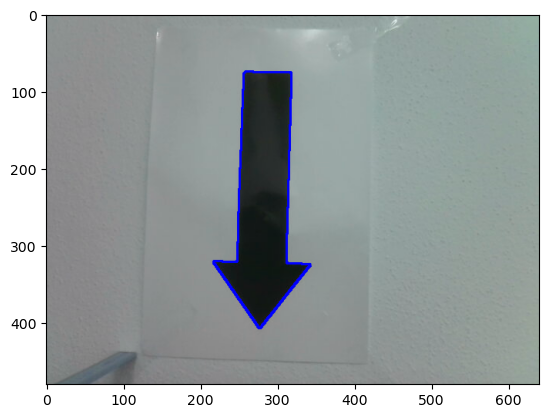

[-26.52830963   1.58942135 508.23930488]
rX: 30.47 rY: -0.24 rZ: -1.33


In [16]:
try:
    _ = est_pos_in_img(img_filename, model)
except Exception as e:
    print(str(e))

508.23930488 mm ~ 500 mm == 50 cm => looks good

ca. 30 deg rotation?

## 70 cm test

In [17]:
img_filename = '../70_cm.jpg'

In [18]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

model already loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1, 1)
[[0.9998861]]


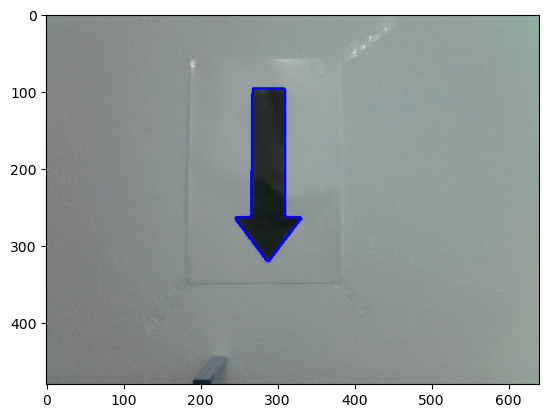

[-31.18782695 -15.95925727 682.66510185]
rX: 1.62 rY: 12.95 rZ: 0.11


In [19]:
try:
    _ = est_pos_in_img(img_filename, model)
except Exception as e:
    print(str(e))

682.66510184 mm ~ 683 mm == 68.3 cm => close to 70 cm

# Translation test

In [20]:
img_filename = '../translation.jpg'

In [21]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

model already loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1, 1)
[[0.9998823]]


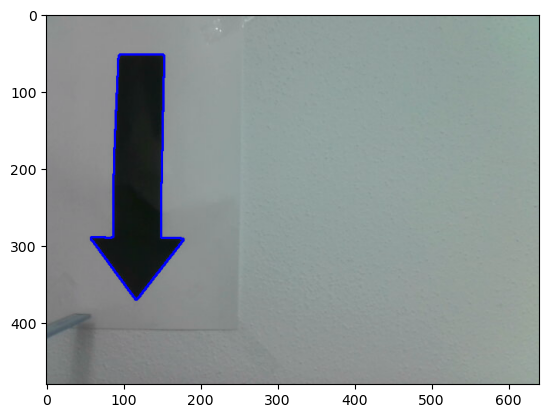

[-145.47334601  -10.54928604  476.8353082 ]
rX: 3.85 rY: -6.09 rZ: -0.56


In [22]:
_ = est_pos_in_img(img_filename, model)

476.8353082 mm ~47.7cm => close to 50 cm

# Sherring test

In [14]:
img_filename = '../sheering.jpg'

In [15]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

load model...


2025-01-06 21:16:55.172985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
(1, 1)
[[0.9999527]]


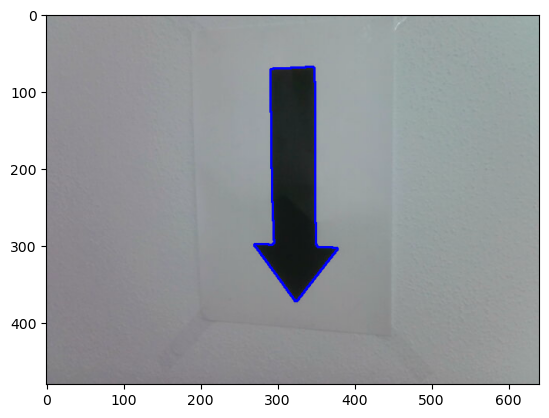

[  1.39433335   0.84854966 509.18158455]
rX: -6.22 rY: -19.40 rZ: 0.92


In [16]:
try:
    _ = est_pos_in_img(img_filename, model)
except Exception as e:
    print(str(e))

509.18158455 ~ 50.9 cm => close to 50 cm; good  
-19.4 deg could be ok (unmeasured)  

# Rotation test

In [26]:
img_filename = '../rotation.jpg'

In [27]:
if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.keras')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

model already loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(2, 1)
[[0.99996907]
 [0.9999267 ]]


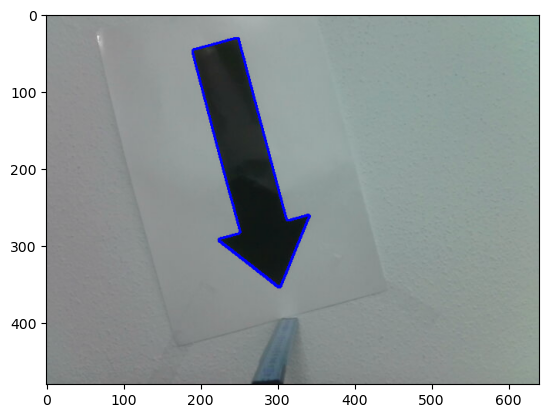

[ -6.96292939   1.81720816 128.07657856]
rX: 178.01 rY: -73.10 rZ: 24.44


In [28]:
_ = est_pos_in_img(img_filename, model)

128.07657856 mm ~ 12.8 cm => far away; distance might be ok and the printed arrow had a minor distance